In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import datetime
import os
import random
import numpy as np
import glob
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.models import resnet50

from PIL import Image

In [2]:
DIR_TRAIN = "data/train/"
DIR_VAL = "data/val/"

In [3]:
class DeepFakeDataset(Dataset):
    def __init__(self, imgs, transforms = None):
        super().__init__()
        self.imgs = imgs
        self.transforms = transforms
    
    def __getitem__(self, idx):
        image_name = self.imgs[idx]
        label = 0
        if ("original" in image_name): label = 1
        label = torch.tensor(label, dtype = torch.float32)
        img = Image.open(image_name).resize((224, 224))
        img = self.transforms(img)
        return img, label, image_name
    
    def __len__(self):
        return len(self.imgs)

In [4]:
def make_dataloader(data_path):
    original_imgs = glob.glob(f"{data_path}/original/*")
    fake_imgs = glob.glob(f"{data_path}/manipulated/*")
    original_imgs.extend(fake_imgs)
    imgs = original_imgs
    transforms = T.Compose([T.ToTensor(),T.Normalize((0, 0, 0), (1, 1, 1))])
    
    if ("train" in data_path) :
        tranforms = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(15),
            T.RandomCrop(204),
            T.ToTensor(),
            T.Normalize((0, 0, 0),(1, 1, 1))
        ])
    else :
        transforms = T.Compose([
            T.ToTensor(),
            T.Normalize((0, 0, 0), (1, 1, 1))
        ])
    
    dataset = DeepFakeDataset(imgs, transforms=transforms)    
    dataloader = DataLoader(dataset = dataset, batch_size = 16, shuffle = True)
    return dataloader

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")

## Logs

In [6]:
train_logs = {"loss" : [], "accuracy" : [], "time" : []}
val_logs = {"loss" : [], "accuracy" : [], "time" : []}

In [7]:
down_boundary = set()
up_boundary = set()

In [8]:
def accuracy(preds, labels, image_name):
    if "val" in image_name[0]:
        for i in range(len(preds)):
            if (0.47 < preds[i] < 0.5):
                down_boundary.add(image_name[i])
            elif (0.5 <= preds[i] < 0.53):
                up_boundary.add(image_name[i])
            
    preds = [1 if preds[i] >= 0.5 else 0 for i in range(len(preds))]
    acc = [1 if preds[i] == labels[i] else 0 for i in range(len(preds))]
    acc = np.sum(acc) / len(preds)
    return (acc * 100)

In [9]:
def one_epoch(dataloader, _best_acc = None):
    epoch_loss = []
    epoch_acc = []
    print(len(down_boundary), len(up_boundary))
    down_boundary.clear()
    up_boundary.clear()
    start = time.time()
    
    for images, labels, image_name in dataloader:
        
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1))
        
        if (_best_acc is None):
            # Reset Gradients
            optimizer.zero_grad()
        
        #Forward
        preds = model(images)
        
        #Calculating Loss
        _loss = loss_function(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        #Calculating Accuracy
        acc = accuracy(preds, labels, image_name)
        epoch_acc.append(acc)
        
        if (_best_acc is None):
            #Backward
            _loss.backward()
            optimizer.step()
            
    ###Overall Epoch Results
    end = time.time()
    total_time = end - start
    
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    if (_best_acc is not None):
        val_logs["loss"].append(epoch_loss)
        val_logs["accuracy"].append(epoch_acc)
        val_logs["time"].append(total_time)
        
        if epoch_acc > _best_acc:
            _best_acc = epoch_acc
            torch.save(model.state_dict(),"resnet50.pth")

            
        #Print Epoch Details
        print("\nValidation")
        print(f"Loss: {round(epoch_loss, 4)}")
        print(f"Acc: {round(epoch_acc, 4)}")
        print(f"Time: {round(total_time, 4)}")
    
    else:
        train_logs["loss"].append(epoch_loss)
        train_logs["accuracy"].append(epoch_acc)
        train_logs["time"].append(total_time)
        
        #Print Epoch Details
        print("\nTraining")
        print(f"Loss: {round(epoch_loss, 4)}")
        print(f"Acc: {round(epoch_acc, 4)}")
        print(f"Time: {round(total_time, 4)}")

In [10]:
model = resnet50(pretrained = True)

model.fc = nn.Sequential(
    nn.Linear(2048, 1, bias = True),
    nn.Sigmoid()
)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Tunable Parameter

In [11]:
# lrs = [0.1, 0.01, 0.001, 0.0001]
# optimizers = [torch.optim.Adam(model.parameters(), lr=lr), torch.optim.SGD(model.parameters(), lr=lr)]
# lr_schedulers = [torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)] 
# loss_functions = [nn.BCELoss, nn.CrossEntropyLoss]

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)
loss_function = nn.BCELoss()
epochs = 2

In [13]:
best_acc = 0
train_dataloader = make_dataloader(DIR_TRAIN)
val_dataloader = make_dataloader(DIR_VAL)
for epoch in range(epochs):
    print(f"\nEpoch: {epoch+1}")
    one_epoch(train_dataloader)
    one_epoch(val_dataloader, best_acc)
    print("\n")


Epoch: 1
0 0

Training
Loss: 0.45
Acc: 76.1989
Time: 124.1573
0 0

Validation
Loss: 0.3291
Acc: 84.5745
Time: 18.4184



Epoch: 2
31 26

Training
Loss: 0.2419
Acc: 89.7869
Time: 125.0135
0 0

Validation
Loss: 0.2732
Acc: 89.0293
Time: 18.623




## Plot Graphs

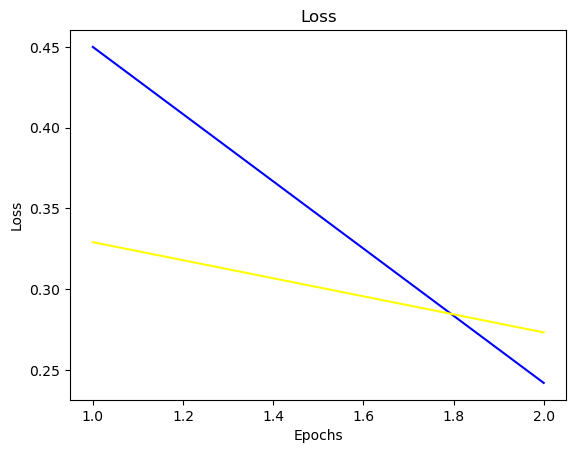

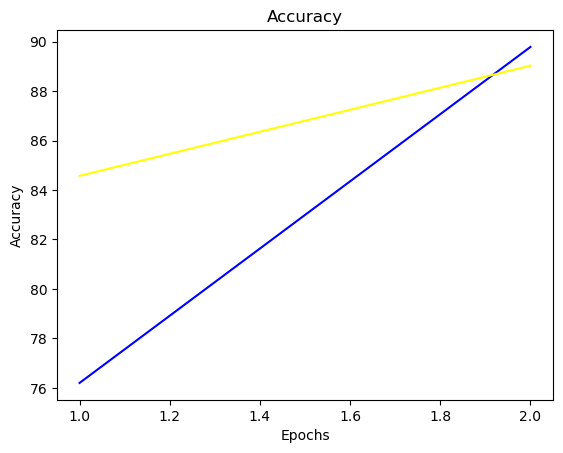

In [14]:
def plot_loss():
    plt.title("Loss")
    plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
    plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'yellow')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()


def plot_acc():
    plt.title("Accuracy")
    plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
    plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'yellow')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()
    
plot_loss()
plot_acc()

### Boundary Cases

In [15]:
print(f"Below Boundary cases: {len(down_boundary)}")
print(f"Above Boundary cases: {len(up_boundary)}")

Below Boundary cases: 12
Above Boundary cases: 22


#### Below Boundary Cases View

Here, we are plotting 4 cases of images that were close to the boundary, but were classified as Manipulate

Text(0.5, 1.0, '3027.png')

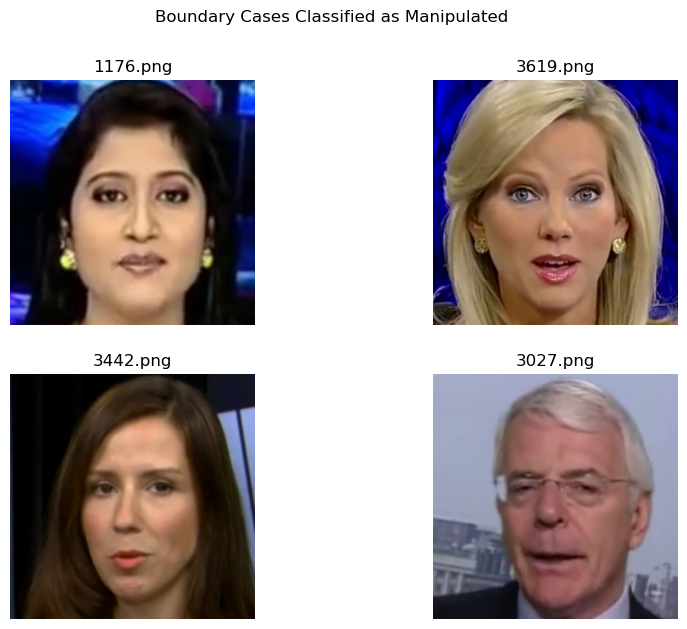

In [16]:
mans = []
for x in down_boundary:
    mans.append(x)

fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 2

fig.suptitle("Boundary Cases Classified as Manipulated")


Image1 = Image.open(mans[0])
Image2 = Image.open(mans[1])
Image3 = Image.open(mans[2])
Image4 = Image.open(mans[3])

fig.add_subplot(rows, columns, 1)  
plt.imshow(Image1)
plt.axis('off')
plt.title(mans[0].split("\\")[-1])
  
fig.add_subplot(rows, columns, 2)
plt.imshow(Image2)
plt.axis('off')
plt.title(mans[1].split("\\")[-1])

fig.add_subplot(rows, columns, 3)  
plt.imshow(Image3)
plt.axis('off')
plt.title(mans[2].split("\\")[-1])
  
fig.add_subplot(rows, columns, 4)
plt.imshow(Image4)
plt.axis('off')
plt.title(mans[3].split("\\")[-1])

Text(0.5, 1.0, '3137.png')

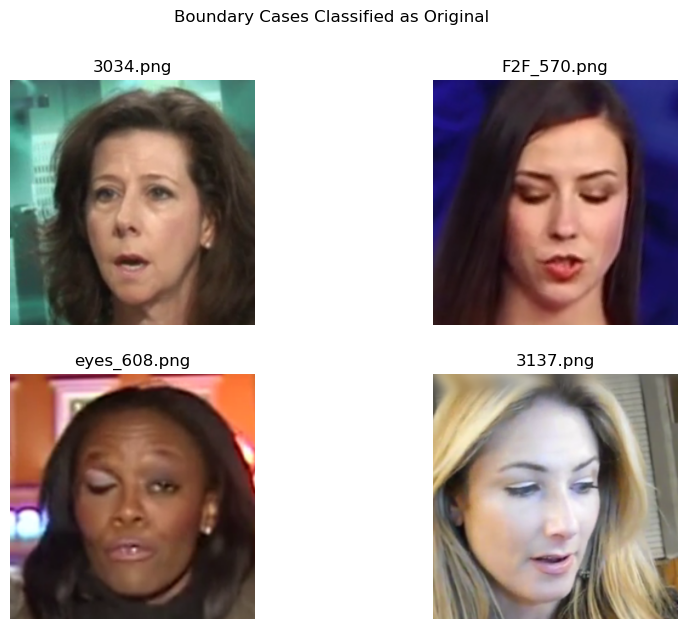

In [17]:
orgs = []
for x in up_boundary:
    orgs.append(x)

fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 2

fig.suptitle("Boundary Cases Classified as Original")

Image1 = Image.open(orgs[0])
Image2 = Image.open(orgs[1])
Image3 = Image.open(orgs[2])
Image4 = Image.open(orgs[3])

fig.add_subplot(rows, columns, 1)  
plt.imshow(Image1)
plt.axis('off')
plt.title(orgs[0].split("\\")[-1])
  
fig.add_subplot(rows, columns, 2)
plt.imshow(Image2)
plt.axis('off')
plt.title(orgs[1].split("\\")[-1])

fig.add_subplot(rows, columns, 3)  
plt.imshow(Image3)
plt.axis('off')
plt.title(orgs[2].split("\\")[-1])
  
fig.add_subplot(rows, columns, 4)
plt.imshow(Image4)
plt.axis('off')
plt.title(orgs[3].split("\\")[-1])

### Parameters' Adjustment

During the develoment process, our team tried the number of parameters and fine-tuned the model to achieve the best result it possibly can. Someo of the results were recorded and placed below as a dataframe to illustrate the reasoning of the decision to use specific parameters in the model.

Some of the most important parameters were learning rate and loss_function. The best model that we found was the one with 0.0001 learning rate and BCELoss - loss_function.

In [71]:
df = pd.read_csv("./params.csv", sep ="\t", header=None)
display(df)

,0,1,2,3,4,5,6,7
0,learning_rate,optimizer,loss_function,Validation Accuracy,Accuracy,Recall,Precision,AUC
1,0.01,Adam,BCELoss,0.71,0.69,0.69,0.65,0.69
2,0.001,Adam,BCELoss,0.69,0.78,0.69,0.75,0.77
3,0.0005,Adam,BCELoss,0.88,0.78,0.72,0.65,0.77
4,0.0001,Adam,BCELoss,0.95,0.87,0.91,0.75,0.77
5,0.00005,Adam,BCELoss,0.95.4,0.88,0.88,0.78,0.88
6,0.00001,Adam,BCELoss,0.88.3,0.84,0.84,0.72,0.84
7,0.000005,Adam,BCELoss,0.86.4,0.79,0.85,0.64,0.8
8,0.0001,SGD,Cross-Entropy,0.66,0.36,0.87,0.32,0.48
9,0.0001,SGD,BCELoss,0.67,0.8,0.74,0.71,0.81
